## 📚 Additional Libraries Import

We import some additional libraries used throughout the project for various purposes:
- File and directory operations (`os`, `shutil`, `copyfile`)
- Time-related functions (`time`)
- Numerical computations with arrays (`numpy`)
- Handling JSON files (`json`)
- Loading Keras models from JSON (`tensorflow.keras.models.model_from_json`)
- Image processing and annotation (`PIL` — `Image`, `ImageDraw`, `ImageFont`)
- Image preprocessing for deep learning (`tensorflow.keras.preprocessing.image.img_to_array`)
- Activation functions from Keras (`tensorflow.keras.activations`)
- Plotting and visualization (`matplotlib.pyplot`)


In [ ]:
import os
import time
import numpy as np
import shutil
from shutil import copyfile
import json
from tensorflow.keras.models import model_from_json
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import activations
import matplotlib.pyplot as plt


## ⚙️ Paths and Parameters for Prediction

This section defines the key variables used during the prediction phase:

- **Model path** where the saved model files are located  
- **Dataset path** pointing to the base folder of the image dataset  
- **Prediction directories** as a list of paths containing images to classify  
- **Loaded model name** to identify which trained model to load  
- **Classification mode** (`multi_class`) to specify if the task is multi-class or not  
- **Confidence threshold** to filter predictions based on probability


In [ ]:
path_model = "modele/dragonball"                  # Path where the model file will be saved
path_data = "data/dragonball/"                    # Path to the image dataset

predict_data_dir = [path_data + "predict/"]       # List of paths to prediction images
loaded_model_name = "dragonball_model"            # Name of the model to be loaded
multi_class = False                               # Set to True for multi-class classification
threshold = 0.75                                  # Confidence threshold for prediction

# Prediction and label storage
predict_file_list = []

## 🔄 Loading Pretrained Models

This section covers how to load a pretrained Keras model from saved files, including:

- Loading the model architecture from a JSON file  
- Loading the model weights from an HDF5 file
- Loading the labels from a TXT file  
- Combining both to restore the complete model for inference or further training  


In [ ]:
def load_model_from_dir(model_dir, model_name, labels_filename="labels.txt"):
    """
    Load a Keras model and class labels from files in a specified directory.

    Args:
        model_dir: str, path to the directory containing model files
        model_name: str, base filename of the model (without extension)
        labels_filename: str, filename of the labels text file (default "labels.txt")

    Returns:
        model: Keras model loaded with architecture and weights
        labels: list of str, class labels loaded from the text file
    """
    json_path = os.path.join(model_dir, model_name + ".json")
    weights_path = os.path.join(model_dir, model_name + ".weights.h5")
    labels_path = os.path.join(model_dir, labels_filename)

    # Load model architecture
    with open(json_path, 'r') as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json)

    # Load weights
    model.load_weights(weights_path)

    print(f"Model loaded from {json_path} and {weights_path}")

    # Load labels
    if os.path.isfile(labels_path):
        with open(labels_path, 'r') as f:
            labels = [line.strip() for line in f.readlines()]
        print(f"Labels loaded from {labels_path}: {labels}")
    else:
        labels = []
        print(f"Labels file not found at {labels_path}. Returning empty label list.")

    return model, labels

# -- Execution section --
model, label_list = load_model_from_dir(path_model, loaded_model_name)


Model loaded from modele/dragonball/dragonball_model.json and modele/dragonball/dragonball_model.weights.h5
Labels loaded from modele/dragonball/labels.txt: ['gohan', 'goku', 'piccolo', 'vegeta']


## 🖼️ Image Prediction and Annotation

In this section, we:

- Gather all image files from the specified prediction directories.
- For each image, preprocess and resize it to match the model input.
- Use the trained model to predict class probabilities.
- Annotate the original image with predicted class labels and their confidence scores.
- Display images with prediction confidence above a defined threshold.
- Organize predicted images into folders named by their predicted class for easier review.


In [ ]:
def get_predict_image_paths(predict_dirs):
    """
    Collect and sort all image file paths from the prediction directories.

    Args:
        predict_dirs: list of directory paths to search for images.

    Returns:
        sorted list of image file paths with extensions png, jpg, jpeg.
    """
    all_files = []
    for path in predict_dirs:
        if os.path.isdir(path):
            all_files.extend([os.path.join(path, f) for f in os.listdir(path)])
    all_files = sorted(all_files)

    # Filter for image files only
    image_files = [f for f in all_files if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    return sorted(image_files)


def predict_and_annotate_images(model, image_paths, labels, multi_class, predict_data_dir, threshold=90):
    """
    Predict classes for a list of images, annotate each image with prediction probabilities,
    and optionally save the annotated images into folders named by predicted class labels.

    Args:
        model: Trained Keras model used for prediction.
        image_paths: List of file paths to the images to predict.
        labels: List of class label strings.
        multi_class: Boolean flag indicating if it is a multi-class classification task.
        predict_data_dir: List of directories containing the prediction images.
        threshold: Confidence threshold (percentage) above which to save annotated images.

    Returns:
        None
    """
    nameImg = 0  # Counter for naming saved images

    print("Labels found:", labels)

    # 1. Determine the base directory to save results based on classification type
    if not multi_class:
        base_dir = os.path.join(os.path.dirname(predict_data_dir[0]), "result")
    else:
        base_dir = predict_data_dir[0]

    # 2. Create the base directory: remove if it exists to start fresh, then create it
    if os.path.isdir(base_dir):
        shutil.rmtree(base_dir)
    os.mkdir(base_dir)

    # 3. Create subdirectories within base_dir for each label to organize predictions
    for label_folder in labels:
        label_dir = os.path.join(base_dir, label_folder)
        if not os.path.isdir(label_dir):
            os.mkdir(label_dir)

    # Load the default font for annotation
    font = ImageFont.load_default()

    # 4. Loop over each image for prediction and annotation
    for image_path in image_paths:
        # Load and preprocess image: convert to RGB, resize to 150x150, normalize pixels
        im = Image.open(image_path).convert('RGB')
        im1 = im.resize((150, 150))
        im1 = img_to_array(im1) / 255.0
        im1 = np.expand_dims(im1, axis=0)

        # Predict class probabilities with the model
        pred = model.predict(im1)

        # Prepare to draw annotations on the original image
        draw = ImageDraw.Draw(im)

        if multi_class:
            # For multi-class, annotate each class probability on separate lines
            y_text = 10
            for i, label in enumerate(labels):
                line = f"{label}: {pred[0][i] * 100:.2f}%"
                draw.text((10, y_text), line, fill='red', font=font)
                y_text += 15  # Move down for the next line
        else:
            # For single-class, annotate only the predicted label and confidence
            max_idx = np.argmax(pred)
            label = labels[max_idx]
            confidence = pred[0][max_idx] * 100
            draw.text((10, 10), f"{label}\n{confidence:.2f}%", fill='red', font=font)

        # Print predicted label and max confidence for logging
        print(label, np.max(pred) * 100)

        # Save annotated image only if prediction confidence exceeds threshold
        if np.max(pred) * 100 >= threshold:
            # Determine destination path based on classification mode
            if multi_class:
                max_idx = np.argmax(pred)
                label = labels[max_idx]

            dest_path = os.path.join(base_dir, label, f"{nameImg}{os.path.splitext(image_path)[1]}")

            # Save the annotated image (not the original)
            im.save(dest_path)

            nameImg += 1


# --- Execution section ---
predict_image_paths = get_predict_image_paths(predict_data_dir)
predict_and_annotate_images(model, predict_image_paths, label_list, multi_class, predict_data_dir)


Labels found: ['gohan', 'goku', 'piccolo', 'vegeta']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
goku 97.01141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
goku 97.294716
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
goku 52.587883
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
vegeta 92.79697
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
gohan 34.16567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
gohan 43.34923
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
goku 88.262344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
vegeta 99.969635
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
vegeta 95.569534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
goku 99.78293
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
goku 34.320896
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
goku 98.55496


## 🔥 Visualizing Saliency Maps for Class-Specific Filters

This section focuses on understanding which parts of an input image influence the model’s prediction the most by:

- Identifying the output layer corresponding to class predictions.
- Temporarily replacing the softmax activation with a linear activation to facilitate gradient calculation.
- Computing the saliency map for a specific class filter, which highlights important pixels affecting the prediction.
- Visualizing this saliency as a heatmap using the 'jet' colormap, enabling intuitive interpretation of model attention.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Visualizing saliency map for predicted class index 1 with confidence 97.01%


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_4
Received: inputs=['Tensor(shape=(1, 150, 150, 3))']
  warnings.warn(msg)


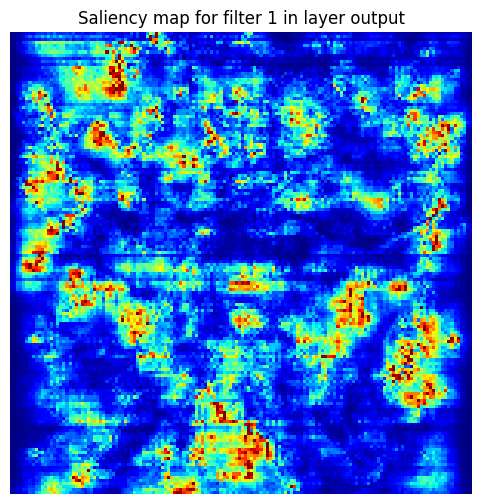

In [ ]:
def find_output_layer_index(model, layer_name="output"):
    """
    Find the index of a layer in the Keras model by its name.

    Args:
        model: Keras model instance
        layer_name (str): Name of the layer to find (default is "output")

    Returns:
        int: Index of the layer in model.layers

    Raises:
        ValueError: If the layer with the given name is not found
    """
    for i, layer in enumerate(model.layers):
        if layer.name == layer_name:
            return i
    raise ValueError(f"Layer {layer_name} not found in model")


def replace_activation_with_linear(model, layer_idx):
    """
    Replace the activation function of a specified layer with a linear activation.

    Args:
        model: Keras model instance
        layer_idx (int): Index of the layer whose activation will be replaced

    Returns:
        model: The modified Keras model with linear activation at specified layer
    """
    model.layers[layer_idx].activation = activations.linear
    return model


def visualize_saliency_for_filter(model, layer_idx, filter_idx=0, seed_input=None):
    """
    Generate and display a saliency map for a specific filter (class) in a given layer.

    Args:
        model: Keras model instance
        layer_idx (int): Index of the target layer to visualize
        filter_idx (int): Index of the filter (e.g., class) to visualize saliency for
        seed_input: Preprocessed input image array (batch size 1) to use as seed

    Returns:
        None: Displays the saliency map using matplotlib
    """
    # Initialize the Saliency object with a model modifier to set linear activation on target layer
    saliency = Saliency(
        model,
        model_modifier=lambda m: replace_activation_with_linear(m, layer_idx),
        clone=True
    )

    # Define a loss function that isolates the output of the chosen filter
    def loss(output):
        return output[:, filter_idx]

    # Compute the saliency map with smoothing for better visualization
    saliency_map = saliency(
        loss,
        seed_input=seed_input,
        smooth_samples=20,
        smooth_noise=0.05
    )

    # Normalize the saliency map for display
    saliency_map = normalize(saliency_map[0])

    # Plot the saliency map using a heatmap color scheme
    plt.imshow(saliency_map, cmap='jet')
    plt.axis('off')
    plt.title(f'Saliency map for filter {filter_idx} in layer {model.layers[layer_idx].name}')
    plt.show()


# --- Execution section ---

# Select the first image from prediction paths (adjust index as needed)
img_path = predict_image_paths[0]

# Load and preprocess the image as done during prediction
im = Image.open(img_path).convert('RGB')
im_resized = im.resize((150, 150))
im_array = img_to_array(im_resized) / 255.0
seed_input = np.expand_dims(im_array, axis=0)

# Find the index of the output layer by name (adjust the name as per your model)
layer_idx = find_output_layer_index(model, layer_name="output")  # e.g. "dense1", "conv1", etc.

# Predict to get the class filter index with the highest confidence
pred = model.predict(seed_input)
filter_idx = np.argmax(pred)

print(f"Visualizing saliency map for predicted class index {filter_idx} with confidence {pred[0][filter_idx]*100:.2f}%")

# Generate and show the saliency map for the selected filter
visualize_saliency_for_filter(model, layer_idx, filter_idx=filter_idx, seed_input=seed_input)
